# En este ejercicio vamos a vectorizar textos y entrenar un resolvedor de tickets.#

<div class="alert alert-block alert-info">
El procesamiento del lenguage natural tiene, entre otros usos : 
<br><br>

 - Construcción de **modelos de ML** cuya entrada es texto libre.<br>
 - **Extracción de tópicos** de un texto.<br>
 - **Auto clasificación** de textos.<br>
 - **Analisis sentiente**.<br>
 - **Traducción** entre idiomas.<br>
<br>
</div>

 
Vamos a construir un predictor de tickets, que dado un ticket nuevo con una incidencia, lo categoriza.

## Fases
- ### Carga del dataset y de las stop words
- ### Preprocesado.
- ### Vectorización del dataset con CountVectorizer.
- ### Transformación del dataset.
- ### Comparativa de clasificadores con kfold.

- ### Bonus: 

## Carga del dataset 


In [1]:
import sys
import IPython
import numpy as np
import pandas as pd
import sklearn as sk


import warnings
warnings.filterwarnings('ignore')
import pandas as pd

# Load data
df = pd.read_csv("datasets/tickets-jobs.csv")



df.head(2)

,id,subject,content,problem
0,169515,Cuenta de uso general para el proyecto IoT en ...,Buenas tardes Queriamos solicitaros una cuenta...,add-ftp-user
1,169982,Wikis Peticion de creacion de wiki iot-SmartCi...,Hola Necesitamos la creacion de una wiki iot-s...,create-wiki


### Instalamos las stop words###


Las stop words son palabras que no añaden significado a un texto (pronombres, interjecciones, frases hechas)


In [2]:
!pip install stop-words

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from stop_words import get_stop_words
##  Como nos llegan tickets en dos idiomas añadimos las palabras de ambos idiomas
stop  = get_stop_words('spanish') + get_stop_words('english')
## Añdimos nuestras propias palabras
stop += ["buenas", "buenos" ,"cid", "dias", "gracias", "hola","mucho","mucha" ,"poder","proyecto","please" ,"saludo","tardes","www"]

print(stop)

['a', 'al', 'algo', 'algunas', 'algunos', 'ante', 'antes', 'como', 'con', 'contra', 'cual', 'cuando', 'de', 'del', 'desde', 'donde', 'durante', 'e', 'el', 'ella', 'ellas', 'ellos', 'en', 'entre', 'era', 'erais', 'eran', 'eras', 'eres', 'es', 'esa', 'esas', 'ese', 'eso', 'esos', 'esta', 'estaba', 'estabais', 'estaban', 'estabas', 'estad', 'estada', 'estadas', 'estado', 'estados', 'estamos', 'estando', 'estar', 'estaremos', 'estará', 'estarán', 'estarás', 'estaré', 'estaréis', 'estaría', 'estaríais', 'estaríamos', 'estarían', 'estarías', 'estas', 'este', 'estemos', 'esto', 'estos', 'estoy', 'estuve', 'estuviera', 'estuvierais', 'estuvieran', 'estuvieras', 'estuvieron', 'estuviese', 'estuvieseis', 'estuviesen', 'estuvieses', 'estuvimos', 'estuviste', 'estuvisteis', 'estuviéramos', 'estuviésemos', 'estuvo', 'está', 'estábamos', 'estáis', 'están', 'estás', 'esté', 'estéis', 'estén', 'estés', 'fue', 'fuera', 'fuerais', 'fueran', 'fueras', 'fueron', 'fuese', 'fueseis', 'fuesen', 'fueses', 'fu

## Preprocesado ##

Quitamos : 
 - casos demasiados infrecuentes, 
 - columnas vacias,  
además, concatenamos el campo "Asunto" y "Cuerpo" de los tickets.



In [4]:
import pandas as pd

# Preprocess
CASES_TO_DELETE=["Problem" ,
                 "artifactory-permisos",
                 "integration-dcip-github",
                 "restart-VM",
                 "artifactory-add-user-grupo",
                 "artifactory-add-repo-local",
                 "crear-maquina-virtual" , "un", "Otros"]


for case in CASES_TO_DELETE : df = df.drop(df[df.problem == case].index)
    
df["problem"][df.problem == "unsuspend"] = "unsuspend-pdihub-user" 
df["problem"][df.problem == "add-users-to-tenant-kilo"] = "add-users-to-tenant" 



# Cargamos DF
df.dropna(subset = ['problem'],inplace=True) 

print("Tipos de problemas, y conteo de tickets por problema")
print(df.problem.value_counts())



try:
    # Quitamos los campos vacios
    df['subject'].fillna('', inplace=True)
    df['content'].fillna('', inplace=True)
    
    # Un solo campo concatenando Subject + Content
    df["ticket"] = df['content'] + df['subject']

except: pass


try:
    # Borrar columnas
    del df['content'] 
    del df['subject']
except: pass



import matplotlib.pyplot as plt

CountStatus = pd.value_counts(df['problem'].values, sort=True)
CountStatus.plot.barh()

df.tail(4)


Tipos de problemas, y conteo de tickets por problema
unsuspend-pdihub-user    102
add-github-user           76
add-users-to-tenant       65
add-pdihub-user           56
add-jira-user             31
create-wiki               23
crearmaquinavirtual       21
add-ftp-user              20
Name: problem, dtype: int64


,id,problem,ticket
714,226651,unsuspend-pdihub-user,Buenos dias Mi usuario art has sido marcado co...
715,226624,add-github-user,Buenos dias He perdido el acceso al repositori...
717,226615,unsuspend-pdihub-user,Estimados Desde el problema suscitado hace un ...
722,226586,crearmaquinavirtual,Hola de cara a poder instalar una maquina para...


In [5]:
from nltk.stem.snowball import SpanishStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

# Create an stemmer, spanish 
ps = SpanishStemmer()
a=[]
df["stem"]="n"
for i, row in df.iterrows():
    a.append( ps.stem(row["ticket"]).replace('acceder', 'acceso').replace('user', 'usuario').replace('access', 'acceso').replace('usuarios', 'usuario'))

    
# Replace stemmized column   
df["stem"]= a 
print(df.head())
df["ticket"] = df["stem"]
del  df["stem"]

       id              problem  \
0  169515         add-ftp-user   
1  169982          create-wiki   
2  170229  crearmaquinavirtual   
3  170397          create-wiki   
4  171179          create-wiki   

                                              ticket  \
0  Buenas tardes Queriamos solicitaros una cuenta...   
1  Hola Necesitamos la creacion de una wiki iot-s...   
2  Hola Jaime Como te he comentado estamos hacien...   
3  Creacion de wiki para dev Ruben Montoro Tercia...   
4  Buenos dias Desde el departamento de GCTO nos ...   

                                                stem  
0  buenas tardes queriamos solicitaros una cuenta...  
1  hola necesitamos la creacion de una wiki iot-s...  
2  hola jaime como te he comentado estamos hacien...  
3  creacion de wiki para dev ruben montoro tercia...  
4  buenos dias desde el departamento de gcto nos ...  


## Vectorización del dataset con CountVectorizer.
<br>
<div class="alert alert-block alert-info">
<br>
**Vectorizar** es pasar el lenguage natural a un conjunto de vectores, donde cada palabra o grupo de palabras es un punto en un espacio n-dimensional. <br><br>

Viene a ser como si tradujeramos el texto a otro lenguage, salvo que ese lenguaje son números.<br><br>

La ventaja de traducirlo a números, es que puedes realizar operaciones matemáticas con el lenguage, en este caso, entrenar un modelo de ML.
</div>

Normalmente para generar el dataset el procedimiento es stopword + stemming (quitar plurales) + bag of words.<br> <br> 
En este caso, vamos a usar [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), el cual en un solo paso:<br> 
 - aplica las stop words, 
 - genera los n-grams (agrupa palabras en grupos de n)
 - cuenta las frecuencias, para generar las features.

El resultado es un dataset cuyas columnas son los n-gramas mas frecuentes, la fila es cada uno de los ticket y cada celda es la frecuencia de ese n-grama en ese ticket.

In [6]:
# CountVectorizer implements both tokenization and occurrence counting
#  in a single class:
MAX_FEATURES=200

from sklearn.feature_extraction.text import CountVectorizer
### 
count = CountVectorizer( max_df=.1,
                        max_features=MAX_FEATURES,
                        stop_words=stop,
                        ngram_range=(1, 3))

X = count.fit_transform(df['ticket'].values)
print(count)
print(X.toarray()  , X.shape , X[0].shape  )


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.1, max_features=200, min_df=1,
        ngram_range=(1, 3), preprocessor=None,
        stop_words=['a', 'al', 'algo', 'algunas', 'algunos', 'ante', 'antes', 'como', 'con', 'contra', 'cual', 'cuando', 'de', 'del', 'desde', 'donde', 'durante', 'e', 'el', 'ella', 'ellas', 'ellos', 'en', 'entre', 'era', 'erais', 'eran', 'eras', 'eres', 'es', 'esa', 'esas', 'ese', 'eso', 'esos', 'esta', 'e...ias', 'gracias', 'hola', 'mucho', 'mucha', 'poder', 'proyecto', 'please', 'saludo', 'tardes', 'www'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 3]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] (394, 200) (1, 200)


Eso son los ngramas mas frecuentes, que han resultado en features.

In [7]:
print(count.get_feature_names())



['acceso github', 'acceso pdihub', 'acceso tenant', 'acceso usuario', 'activity', 'admins', 'aislada', 'aislada hi', 'aislada hi inet', 'alberto', 'antemano', 'antonio', 'asunto', 'aura', 'baja', 'borja', 'business', 'carlos', 'cc', 'cdn', 'centum', 'cloud', 'cloud eu', 'cloud eu mad', 'cloud services', 'com asunto', 'com orgs', 'com orgs telefonica', 'com signature', 'com skype', 'com telefonica', 'com usuario', 'comunicacion', 'comunicacion madrid', 'confidencial', 'copia', 'correo', 'correo electronico', 'crear', 'cualquier', 'cuenta pdihub', 'daniel', 'datos', 'david', 'david peralesferreratelefonica', 'david peralesferreratelefonica com', 'dentro', 'destinatario', 'dev', 'development', 'digital', 'distrito telefonica', 'documento', 'dormant', 'edificio', 'electronico', 'enviado', 'epgtid', 'error', 'españa', 'eu', 'eu mad', 'eu mad instantservers', 'exttelefonica', 'exttelefonica com', 'francisco', 'franciscojavier', 'ftp', 'ftp tid', 'garcia', 'gb', 'gif', 'gif https', 'git', 'gi

## Transformación del dataset.


- Generamos un dataset a partir del CountVectorizer, por legibilidad.
(Por defecto utiliza un formato optimizado memoria que se llama sparse matrix, donde solo se representan los 1, y no los 0.)


In [8]:
from pandas import DataFrame

df_vectorizado = DataFrame(X.A, columns=count.get_feature_names() ) 

df_vectorizado = df_vectorizado.astype(bool).astype(int)

# Añadimos el campo problem, que sera el campo a predecir
df_vectorizado["problem"] = df["problem"] 
df_vectorizado["id"] = df["id"] 
df_vectorizado.dropna(subset = ['problem'],inplace=True) 

df_vectorizado.head()


,acceso github,acceso pdihub,acceso tenant,acceso usuario,activity,admins,aislada,aislada hi,aislada hi inet,alberto,...,usuario github,usuario jira,usuario pdihub,usuario tid,utf,video,volver,wiki,problem,id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,add-ftp-user,169515.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,create-wiki,169982.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,crearmaquinavirtual,170229.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,create-wiki,170397.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,create-wiki,171179.0


In [9]:
## Generamos X e Y, para entrenar los modelos

In [10]:
from sklearn.preprocessing import LabelEncoder
import sys

try             : del df_vectorizado["id"] 
except Exception: pass

y = df_vectorizado.iloc[:,-1]
X = df_vectorizado.drop('problem', axis=1)

y.head()




0           add-ftp-user
1            create-wiki
2    crearmaquinavirtual
3            create-wiki
4            create-wiki
Name: problem, dtype: object

In [11]:
X.head()

,acceso github,acceso pdihub,acceso tenant,acceso usuario,activity,admins,aislada,aislada hi,aislada hi inet,alberto,...,use,uso,usuario github,usuario jira,usuario pdihub,usuario tid,utf,video,volver,wiki
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Comparativa de clasificadores con kfold.

Como en el ejercicio anterior, probamos una bateria de modelos y validamos su score con k-fold.


In [12]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import sklearn.model_selection
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from mlxtend.classifier import EnsembleVoteClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB

NUM_SPLITS=8

kfold = KFold(n_splits=NUM_SPLITS)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                     test_size=0.20,
                     random_state=1)
    
    
names = ["Nearest Neighbors", 
         "Linear SVM", 
         "RBF SVM", 
         "Decision Tree", 
         "Random Forest", 
         "MLPClassifier", 
         "AdaBoost",
         "XGBoost" 
        ]


classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    XGBClassifier()
]


for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    scores = model_selection.cross_val_score(clf, X, y,  cv=kfold )
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), name))
    score = clf.score(X_test, y_test)

# Practicamos tambien el voto de algoritmos, por si fuera mas preciso
eclf = EnsembleVoteClassifier(clfs=classifiers, 
                              weights=[1,1,1,1,1,1,1,1])
scores = model_selection.cross_val_score(eclf, X, y,  cv=kfold )
print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), "EnsembleVoteClassifier"))
  
print("Fin")




Accuracy: 0.31 (+/- 0.18) [Nearest Neighbors]
Accuracy: 0.10 (+/- 0.05) [Linear SVM]
Accuracy: 0.04 (+/- 0.04) [RBF SVM]
Accuracy: 0.40 (+/- 0.21) [Decision Tree]
Accuracy: 0.11 (+/- 0.06) [Random Forest]
Accuracy: 0.37 (+/- 0.25) [MLPClassifier]
Accuracy: 0.29 (+/- 0.09) [AdaBoost]
Accuracy: 0.37 (+/- 0.25) [XGBoost]
Accuracy: 0.33 (+/- 0.23) [EnsembleVoteClassifier]
Fin


(261, 2)


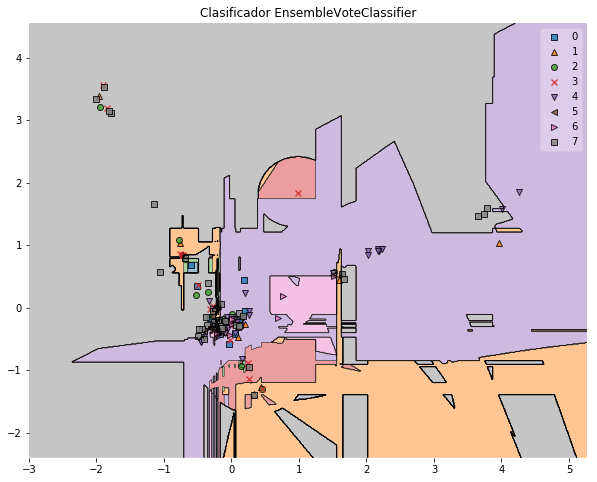

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA



le = LabelEncoder()
y2 = le.fit_transform(y)
y = y2

#print(X,y)

###### Generamos un nuevo dataframe con solo dos componentes.
pca_2c = PCA(n_components=2)
X_pca_2c = pca_2c.fit_transform(X)
print(X_pca_2c.shape)


pca_2c.explained_variance_ratio_.sum()

###### Miramos el gráfico
from sklearn.naive_bayes import GaussianNB 
from mlxtend.plotting import plot_decision_regions



X     = X_pca_2c
model = eclf  
clf   = model
clf.fit(X, y)

# Generamos el gráfico
fig = plt.figure(figsize=(10,8))
fig = plot_decision_regions(X=X, y=y, clf=clf)


plt.title("Clasificador EnsembleVoteClassifier")




## Bonus : Vectorización con TF-IDF

Vamos a utilizar otro vectorizador, usada para extraer tópicos relevantes un conjunto de texto, TfidfVectorizer.
<br>
<div class="alert alert-block alert-info">

Tf-idf (del inglés Term frequency – Inverse document frequency), frecuencia de término – frecuencia inversa de documento (o sea, la frecuencia de ocurrencia del término en la colección de documentos)<br><br>Es una medida numérica que expresa cuán relevante es una palabra para un documento en una colección.</div>



In [14]:


from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer( max_df=.1,
                        max_features=MAX_FEATURES,
                        stop_words=stop,
                        ngram_range=(1, 3))

X = count.fit_transform(df['ticket'].values)
print( X.shape , X[0].shape  )

from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X)
X_train_tf = tf_transformer.transform(X)
X_train_tf.shape
X_train_tf




(394, 200) (1, 200)


<394x200 sparse matrix of type '<class 'numpy.float64'>'
	with 3376 stored elements in Compressed Sparse Row format>

Primero vectorizamos con el **TfidfVectorizer**
Vemos que el dataframe sale distinto, que con el **CountVectorizer**

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np




tf = TfidfVectorizer(analyzer='word',
                     ngram_range=(1,3),
                     max_features=MAX_FEATURES,
                     min_df = 0, 
                     stop_words = stop, 
                     sublinear_tf=True)

X_train_tf =  tf.fit_transform(df['ticket'].values)

tf_transformer = TfidfTransformer(use_idf=False).fit(X)
feature_names = tf.get_feature_names()

X = tf.fit_transform(df['ticket'].values)


    

df_vectorizado = DataFrame(X.A, columns=tf.get_feature_names() ) 
df_vectorizado_short =DataFrame(X.A, columns=tf.get_feature_names() ) 

# Añadimos el campo problem, que sera el campo a predecir
df_vectorizado["problem"] = df["problem"] 

df_vectorizado["id"] = df["id"] 
df_vectorizado.dropna(subset = ['problem'],inplace=True) 

print(df_vectorizado.shape)
for c in df_vectorizado.columns : print (c)

df_vectorizado

(261, 202)
acceso
acceso pdihub
acceso tenant
acceso usuario
activity
admins
aislada
aislada hi
aislada hi inet
alberto
alta
alta usuario
antonio
asunto
aura
borja
cc
cdn
cloud
cloud eu
cloud eu mad
cloud services
com
com asunto
com mailto
com orgs
com orgs telefonica
com signature
comunicacion
comunicacion madrid
confidencial
copia
correo
cualquier
cuenta
cuenta pdihub
dar
dar alta
datos
david
david peralesferreratelefonica
david peralesferreratelefonica com
dentro
destinatario
dev
development
distrito
distrito telefonica
dormant
edificio
email
enviado
epg
epgtid
error
españa
eu
eu mad
eu mad instantservers
exttelefonica
exttelefonica com
favor
francisco
ftp
ftp tid
garcia
gb
gif
gif https
github
github com
github telefonica
global
global cloud
global cloud services
gomez
gonzalez
grupo
hi
hi inet
http
https
https github
https github com
https pdihub
https pdihub hi
image
image png
inet
informacion
instantservers
instantservers telefonica
instantservers telefonica com
issues
issues pu

,acceso,acceso pdihub,acceso tenant,acceso usuario,activity,admins,aislada,aislada hi,aislada hi inet,alberto,...,usuario,usuario github,usuario jira,usuario pdihub,usuario tid,utf,video,wiki,problem,id
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.076389,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,add-ftp-user,169515.0
1,0.401693,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.150362,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.555533,create-wiki,169982.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,crearmaquinavirtual,170229.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.318858,create-wiki,170397.0
4,0.085798,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.365398,create-wiki,171179.0
5,0.324743,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.130577,0.000000,0.000000,0.000000,0.460206,0.0,0.000000,0.000000,add-users-to-tenant,171347.0
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,crearmaquinavirtual,171384.0
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.094591,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,add-users-to-tenant,171578.0
8,0.350316,0.000000,0.000000,0.429487,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.238496,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,add-users-to-tenant,172094.0
9,0.271001,0.000000,0.000000,0.332247,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.184499,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,add-users-to-tenant,173104.0


Usamos un array de clasificadores, entre ellos el clasificador [MultinomialNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html). <br>Este clasificador es específico para el cálculo de frencuencia del conteo de palabras.



In [16]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import sklearn.model_selection
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB


X = df_vectorizado_short.values
y = df["problem"]

le = LabelEncoder()
y2 = le.fit_transform(y)
y = y2


NUM_SPLITS=8

kfold = KFold(n_splits=NUM_SPLITS)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                     test_size=0.20,
                     random_state=1)
    
    
names = ["Nearest Neighbors", 
         "RBF SVM", 
         "Decision Tree", 
         "Random Forest", 
         "MLPClassifier", 
         "AdaBoost",
         "Multinomial NB",
         "XGBoost"
        ]


classifiers = [
    KNeighborsClassifier(3),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    MultinomialNB(),
    XGBClassifier()
]


for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    scores = model_selection.cross_val_score(clf, X, y,  cv=kfold )
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), name))
    score = clf.score(X_test, y_test)

# Practicamos tambien el voto de algoritmos, por si fuera mas preciso
eclf = EnsembleVoteClassifier(clfs=classifiers, 
                              weights=[1,1,1,1,1,1,1,1])
scores = model_selection.cross_val_score(eclf, X, y,  cv=kfold )
print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), "EnsembleVoteClassifier"))
  
print("Fin")




Accuracy: 0.67 (+/- 0.05) [Nearest Neighbors]
Accuracy: 0.71 (+/- 0.13) [RBF SVM]
Accuracy: 0.65 (+/- 0.08) [Decision Tree]
Accuracy: 0.45 (+/- 0.12) [Random Forest]
Accuracy: 0.82 (+/- 0.09) [MLPClassifier]
Accuracy: 0.45 (+/- 0.14) [AdaBoost]
Accuracy: 0.74 (+/- 0.10) [Multinomial NB]
Accuracy: 0.84 (+/- 0.07) [XGBoost]
Accuracy: 0.80 (+/- 0.08) [EnsembleVoteClassifier]
Fin


Vemos que hemos obtenido una precisión muy alta.
Visualizamos la matriz de confusión, y el gráfico.

Sizes are :  (394, 2) (394,) <class 'numpy.ndarray'> <class 'numpy.ndarray'> [-735.09252572 1274.57490821]


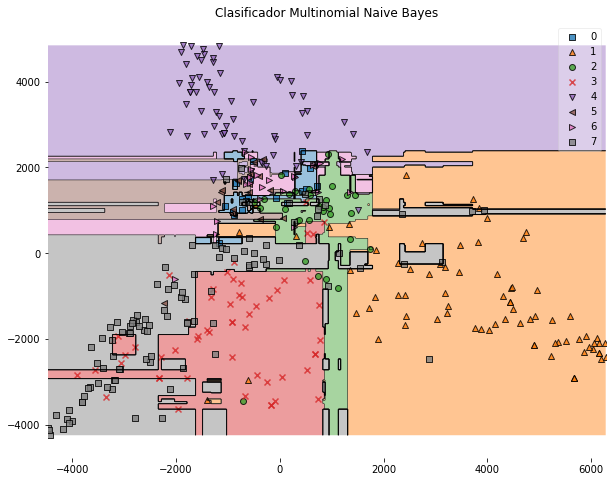

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA


X = df_vectorizado_short.values
y = df["problem"]

le = LabelEncoder()
y2 = le.fit_transform(y)
y = y2



###### Generamos un nuevo dataframe con solo dos componentes.
pca_2c = PCA(n_components=2)
X_pca_2c = pca_2c.fit_transform(X)


pca_2c.explained_variance_ratio_.sum()

###### Miramos el gráfico
from mlxtend.plotting import plot_decision_regions

X     = X_pca_2c

# Transformamos el intervalo de (-1,1) a (0,1000), porque el PCA te lo da valores normalizados,
# pero el MultinomialNB no admite frecuencias negativas de palabras. 
#X=X+1
X=X * 10000
clf = XGBClassifier()
clf.fit(X, y)

print ("Sizes are : ", X.shape, y.shape, type(X), type(y),X[0] )

# Generamos el gráfico
#
fig = plt.figure(figsize=(10,8))
fig = plot_decision_regions(X=X, y=y, clf=clf)


plt.title("Clasificador Multinomial Naive Bayes")





## La matrix de confusión.

 - Nos ayudará a saber que casos son los que menos aciertan (hay que añadir mas tickets de ese caso al dataset para categorizarlo mejor.
                                                             
 - Tambien cuales son las confusiones mas frecuentes entre dos casos.                                                           
                                                             
    


In [28]:
# Imprimimos la matriz de confusin
from sklearn.metrics import confusion_matrix
from pandas_ml import ConfusionMatrix
import matplotlib.pyplot as plt



X = df_vectorizado_short.values
y = df["problem"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                     test_size=0.2)
# Train
clf = XGBClassifier()
clf.fit(X_train, y_train)
# Test
prediction = clf.predict(X_test)

#print(X_test.shape, prediction.shape,y_test.shape, prediction,y_test)
#print(prediction)

# Get confussion matrix
cm = ConfusionMatrix(y_true=y_test, y_pred=prediction)

print("\nLos detalles de la clasificacion son :\n" )


from sklearn.metrics import classification_report
print(classification_report(y_true=y_test, y_pred=prediction))





    


Los detalles de la clasificacion son :

                       precision    recall  f1-score   support

         add-ftp-user       0.83      1.00      0.91         5
      add-github-user       1.00      0.82      0.90        17
        add-jira-user       0.62      1.00      0.76         8
      add-pdihub-user       0.77      0.71      0.74        14
  add-users-to-tenant       1.00      1.00      1.00         9
  crearmaquinavirtual       1.00      0.60      0.75         5
          create-wiki       1.00      0.75      0.86         4
unsuspend-pdihub-user       0.72      0.76      0.74        17

          avg / total       0.85      0.82      0.82        79



The **precision** is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives.
The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The **recall** is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives.
The recall is intuitively the ability of the classifier to find all the positive samples.

The **F-beta** score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The **support** is the number of occurrences of each class in y_true.

Para pintar la matriz de confusión definimos una función que la pinte, plot_confusion_matrix. 

Es solo para pintar la CM (Credits to https://www.kaggle.com/grfiv4/plot-a-confusion-matrix)

In [19]:

import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

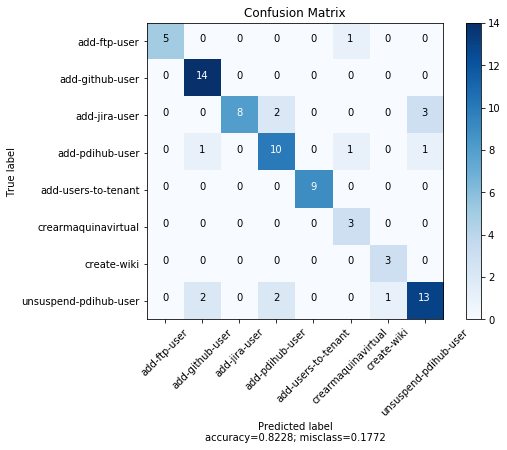

In [30]:
# Pintamos la matriz de confusion
target_names =['add-ftp-user', 
               'add-github-user', 
               'add-jira-user',
               'add-pdihub-user', 
               'add-users-to-tenant', 
               'crearmaquinavirtual',
               'create-wiki', 
               'unsuspend-pdihub-user']



cm = confusion_matrix(y_test, prediction)

plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = target_names,
                      title        = "Confusion Matrix")




Hacemos unos cuantos ejemplos de nuestro resolvedor de tickets.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.utils import np_utils


count = CountVectorizer( max_df=.1,
                        max_features=MAX_FEATURES,
                        stop_words=stop,
                        ngram_range=(1, 3))
X = count.fit_transform(df['ticket'].values)
df_vectorizado = DataFrame(X.A, columns=count.get_feature_names() ) 



tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1,3),
                     max_features=MAX_FEATURES,
                     min_df = 0, 
                     stop_words = stop, 
                     sublinear_tf=True)

tfidf =  tfidf_vectorizer.fit_transform(df['ticket'].values)



X = df_vectorizado.values
y = df["problem"]


# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
y = np_utils.to_categorical(encoded_Y)

print(X,y[0:5],y[100:105])



X_train, X_test, y_train, y_test = train_test_split(X, y, 
                     test_size=0.20,
                     random_state=1)
    


Using TensorFlow backend.


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 3]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] [[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]] [[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]]


In [22]:

from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model



model = Sequential()
model.add(Dense(units=500, activation='relu', input_dim=tfidf.shape[1]))
model.add(Dense(8, activation='softmax'))

#model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=["binary_accuracy"])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

"""
model = Sequential()
model.add(Dense(8, input_dim=4, activation='relu'))
model.add(Dense(3, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model = Sequential()
model.add(Dense(units=100, activation='relu', input_dim=tf.shape[1]))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=["binary_accuracy"])
"""
model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               100500    
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 4008      
Total params: 104,508
Trainable params: 104,508
Non-trainable params: 0
_________________________________________________________________


In [23]:
print(tfidf.shape[1],
      X_train.shape, 
      y_test.shape)
model.fit(X_train, y_train, epochs=50, batch_size=128)


200 (315, 200) (79, 8)
Epoch 1/50
315/315 [==============================] - 0s 659us/step - loss: 2.0645 - acc: 0.1905
Epoch 2/50
315/315 [==============================] - 0s 36us/step - loss: 1.7723 - acc: 0.5302
Epoch 3/50
315/315 [==============================] - 0s 36us/step - loss: 1.5849 - acc: 0.6254
Epoch 4/50
315/315 [==============================] - 0s 36us/step - loss: 1.4394 - acc: 0.6889
Epoch 5/50
315/315 [==============================] - 0s 35us/step - loss: 1.3201 - acc: 0.7524
Epoch 6/50
315/315 [==============================] - 0s 36us/step - loss: 1.2130 - acc: 0.8000

In [25]:


docs_new = ['Quiero una wiki', 
            'Tengo suspendido mi usuario de pdihub',
            "Me gustaria añadir un usuario a mi tenant de openstack kilo",
            "Necesito un usuario para un nuevo proyecto en jira",
            "Quiero solicitar una maquina virtual nueva de vmware",
            "Necesito usar el ftp de ftp.tid.es",
            "Apuntame una licencia para github , para la organización de Aura ."]



X_new_counts = count.transform(docs_new)
#X_new_counts = tfidf_vectorizer.transform(docs_new)

X_new_tfidf = tf_transformer.transform(X_new_counts)

predicted = model.predict(X_new_tfidf)


predicted


array([[0.03114898, 0.07759826, 0.04319782, 0.07509784, 0.04983292,
        0.03437034, 0.4766834 , 0.21207036],
       [0.01326133, 0.03516816, 0.05072519, 0.36436278, 0.02157125,
        0.01522634, 0.01490702, 0.484778  ],
       [0.05195309, 0.04772236, 0.03513796, 0.05592535, 0.631369  ,
        0.02975743, 0.03124475, 0.11689014],
       [0.02700669, 0.05974692, 0.5439848 , 0.07397518, 0.04941624,
        0.02831618, 0.03395053, 0.18360354],
       [0.04129147, 0.07569317, 0.0322342 , 0.10462709, 0.0481348 ,
        0.33715898, 0.06796636, 0.2928939 ],
       [0.5695981 , 0.0537332 , 0.03675352, 0.08461866, 0.04813913,
        0.03205745, 0.03321856, 0.14188142],
       [0.01765319, 0.1445034 , 0.06298214, 0.06875741, 0.0394269 ,
        0.02027054, 0.02742089, 0.61898553]], dtype=float32)

In [26]:
import numpy as np

casos=[]
certezas=[]
for caso in predicted:
    casos.append(encoder.inverse_transform(caso.argmax(axis=0)))
 
predicted_weights = DataFrame(predicted,columns=encoder.classes_)
predicted_weights["casos"] = casos
predicted_weights["problema"] = docs_new



predicted_weights

,add-ftp-user,add-github-user,add-jira-user,add-pdihub-user,add-users-to-tenant,crearmaquinavirtual,create-wiki,unsuspend-pdihub-user,casos,problema
0,0.031149,0.077598,0.043198,0.075098,0.049833,0.034370,0.476683,0.212070,create-wiki,Quiero una wiki
1,0.013261,0.035168,0.050725,0.364363,0.021571,0.015226,0.014907,0.484778,unsuspend-pdihub-user,Tengo suspendido mi usuario de pdihub
2,0.051953,0.047722,0.035138,0.055925,0.631369,0.029757,0.031245,0.116890,add-users-to-tenant,Me gustaria añadir un usuario a mi tenant de o...
3,0.027007,0.059747,0.543985,0.073975,0.049416,0.028316,0.033951,0.183604,add-jira-user,Necesito un usuario para un nuevo proyecto en ...
4,0.041291,0.075693,0.032234,0.104627,0.048135,0.337159,0.067966,0.292894,crearmaquinavirtual,Quiero solicitar una maquina virtual nueva de ...
5,0.569598,0.053733,0.036754,0.084619,0.048139,0.032057,0.033219,0.141881,add-ftp-user,Necesito usar el ftp de ftp.tid.es
6,0.017653,0.144503,0.062982,0.068757,0.039427,0.020271,0.027421,0.618986,unsuspend-pdihub-user,"Apuntame una licencia para github , para la or..."


## Re-Bonus : Vectorización con Keras

Vamos a utilizar un modulo de keras, para entrenar los datos del TFIDF vectorizer

<br>

In [27]:
from IPython.display import display, HTML


 


docs_new = ['Quiero una wiki', 
            'Tengo suspendido mi usuario de pdihub',
            "Me gustaria añadir un usuario a mi tenant de openstack kilo",
            "Necesito un usuario para un nuevo proyecto en jira",
            "Quiero solicitar una maquina virtual nueva de vmware",
            "Necesito usar el ftp de ftp.tid.es",
            "Apuntame una licencia para github , para la organización de Aura ."]



X = df_vectorizado_short.values
y = df["problem"]


clf = MultinomialNB()
clf.fit(X, y)

X_new_counts = count.transform(docs_new)
X_new_tfidf = tf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)


# Cabecera de la tabla
s = f"""
  <h1> Pruebas de textos</h1> 
  <table>
    <tr>
      <th>Ticket</th>
      <th>Caso predicho CountVectorizer</th>
      <th>Caso predicho Deep Learning</th>
    </tr>"""
    
# Cuerpo de la tabla
for doc, category,caso in zip(docs_new, predicted,casos):
   # Cuerpo de la tabla
    s = s + f"""
        <tr>
          <td>{doc}</td>
          <td>{category}</td>
          <td>{caso}</td>
        </tr>"""

# Pie de la tabla
s = s + f"""</table><br>"""


display(HTML(s))





Ticket,Caso predicho CountVectorizer,Caso predicho Deep Learning
Quiero una wiki,create-wiki,create-wiki
Tengo suspendido mi usuario de pdihub,add-jira-user,unsuspend-pdihub-user
Me gustaria añadir un usuario a mi tenant de openstack kilo,add-github-user,add-users-to-tenant
Necesito un usuario para un nuevo proyecto en jira,unsuspend-pdihub-user,add-jira-user
Quiero solicitar una maquina virtual nueva de vmware,add-users-to-tenant,crearmaquinavirtual
Necesito usar el ftp de ftp.tid.es,add-users-to-tenant,add-ftp-user
"Apuntame una licencia para github , para la organización de Aura .",unsuspend-pdihub-user,unsuspend-pdihub-user
